In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

In [ ]:
 Build two simple linear regression models from the provided titanic dataset, each using a different single attribute. Additionally, explore the data and compare the accuracy of the two models.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [3]:
from pathlib import Path
import pandas as pd

DATA_PATH = "data/titanic.csv"  

def resolve_col(df, name):
    lower = {c.lower(): c for c in df.columns}
    assert name.lower() in lower, f"Missing required column '{name}' in {list(df.columns)}"
    return lower[name.lower()]

df = pd.read_csv(DATA_PATH) if str(DATA_PATH).lower().endswith(".csv") else pd.read_parquet(DATA_PATH)
df = df.drop_duplicates().reset_index(drop=True)

TARGET  = resolve_col(df, "survived")
ATTR_A  = resolve_col(df, "sex")
ATTR_B  = resolve_col(df, "pclass")

print("Using columns:", {"TARGET": TARGET, "ATTR_A": ATTR_A, "ATTR_B": ATTR_B})
print("Rows/Cols:", df.shape)


Using columns: {'TARGET': 'Survived', 'ATTR_A': 'Sex', 'ATTR_B': 'Pclass'}
Rows/Cols: (891, 12)


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

          count unique   top freq      mean       std  min  25%  50%  75%  max
Sex         891      2  male  577       NaN       NaN  NaN  NaN  NaN  NaN  NaN
Pclass    891.0    NaN   NaN  NaN  2.308642  0.836071  1.0  2.0  3.0  3.0  3.0
Survived  891.0    NaN   NaN  NaN  0.383838  0.486592  0.0  0.0  0.0  1.0  1.0
Missing rates:
 Sex         0.0
Pclass      0.0
Survived    0.0
dtype: float64
sex unique: ['male' 'female']
pclass unique: [3 1 2]
survived value counts:
 Survived
0    549
1    342
Name: count, dtype: int64
sex counts:
 Sex
male      577
female    314
Name: count, dtype: int64
pclass counts:
 Pclass
3    491
1    216
2    184
Name: count, dtype: int64


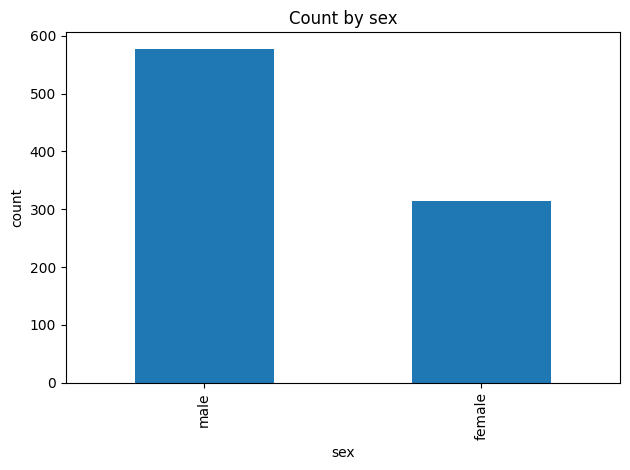

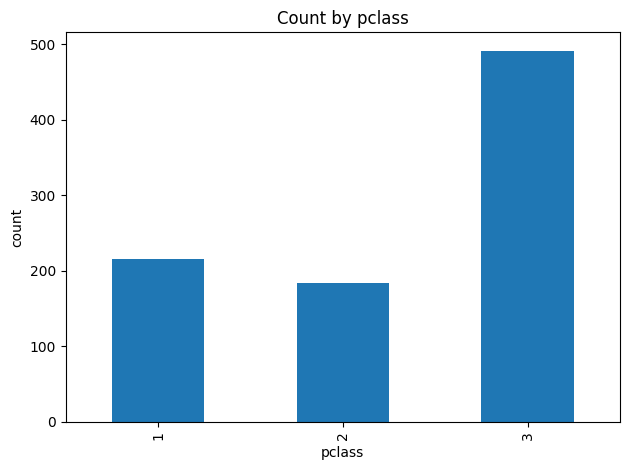

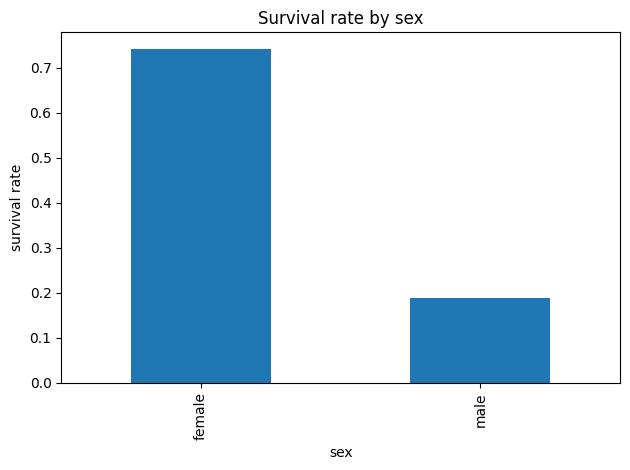

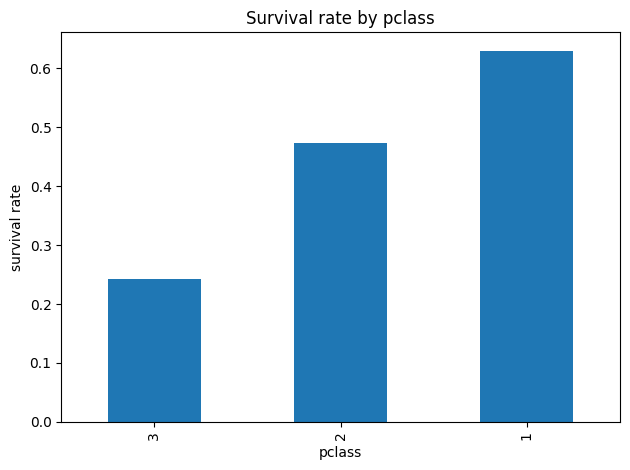

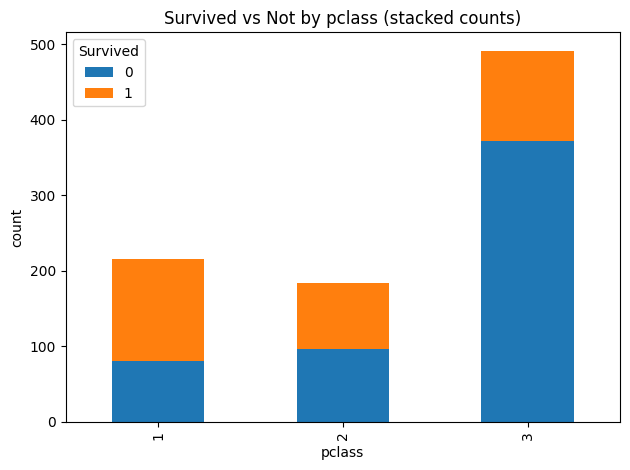

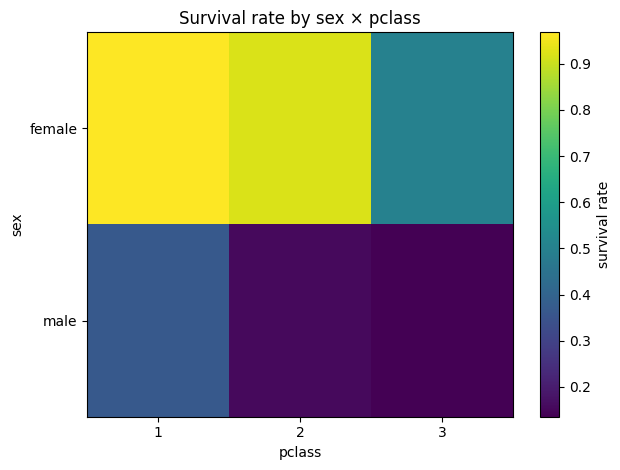

In [12]:
print(df[[ATTR_A, ATTR_B, TARGET]].describe(include="all").T)
print("Missing rates:\n", df[[ATTR_A, ATTR_B, TARGET]].isna().mean())

print("sex unique:", df[ATTR_A].dropna().unique()[:10])
print("pclass unique:", df[ATTR_B].dropna().unique()[:10])
print("survived value counts:\n", df[TARGET].value_counts(dropna=False))

print("sex counts:\n", df[ATTR_A].value_counts(dropna=False))
print("pclass counts:\n", df[ATTR_B].value_counts(dropna=False))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df[ATTR_A].value_counts(dropna=False).plot(kind="bar")
plt.title("Count by sex")
plt.xlabel("sex"); plt.ylabel("count"); plt.tight_layout(); plt.show()

df[ATTR_B].value_counts(dropna=False).sort_index().plot(kind="bar")
plt.title("Count by pclass")
plt.xlabel("pclass"); plt.ylabel("count"); plt.tight_layout(); plt.show()

surv_by_sex = df.groupby(ATTR_A)[TARGET].mean().sort_values(ascending=False)
surv_by_sex.plot(kind="bar")
plt.title("Survival rate by sex")
plt.xlabel("sex"); plt.ylabel("survival rate"); plt.tight_layout(); plt.show()

surv_by_pclass = df.groupby(ATTR_B)[TARGET].mean().sort_values()
surv_by_pclass.plot(kind="bar")
plt.title("Survival rate by pclass")
plt.xlabel("pclass"); plt.ylabel("survival rate"); plt.tight_layout(); plt.show()

stack_counts = df.groupby([ATTR_B, TARGET]).size().unstack(fill_value=0).sort_index()
stack_counts.plot(kind="bar", stacked=True)
plt.title("Survived vs Not by pclass (stacked counts)")
plt.xlabel("pclass"); plt.ylabel("count"); plt.tight_layout(); plt.show()

pivot_rate = df.pivot_table(index=ATTR_A, columns=ATTR_B, values=TARGET, aggfunc="mean")
plt.imshow(pivot_rate.values, aspect="auto")
plt.title("Survival rate by sex × pclass")
plt.xlabel("pclass"); plt.ylabel("sex")
plt.colorbar(label="survival rate")
plt.xticks(ticks=np.arange(len(pivot_rate.columns)), labels=list(pivot_rate.columns))
plt.yticks(ticks=np.arange(len(pivot_rate.index)), labels=list(pivot_rate.index))
plt.tight_layout(); plt.show()


# 4.Prepare the Data


Apply any data transformations and explain what and why


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

sex_map = {"male": 1, "female": 0}
df["_sex_num"] = df[ATTR_A].astype(str).str.lower().map(sex_map)

if df["_sex_num"].isna().any():
    mode_val = df["_sex_num"].mode(dropna=True).iloc[0]
    df["_sex_num"] = df["_sex_num"].fillna(mode_val)

df["_pclass_num"] = pd.to_numeric(df[ATTR_B], errors="coerce")
if df["_pclass_num"].isna().any():
    df["_pclass_num"] = df["_pclass_num"].fillna(df["_pclass_num"].median())

y = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

XA = df[["_sex_num"]]  
XB = df[["_pclass_num"]]

# 60/20/20 split
XA_train, XA_tmp, y_train, y_tmp = train_test_split(XA, y, test_size=0.40, random_state=42, stratify=y)
XA_valid, XA_test, y_valid, y_test = train_test_split(XA_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp)

XB_train = XB.loc[XA_train.index]
XB_valid = XB.loc[XA_valid.index]
XB_test  = XB.loc[XA_test.index]


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

pipe_a = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("model", LinearRegression())
])

pipe_b = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("model", LinearRegression())
])

# Cross-val MAE (lower is better)
cv_a = cross_val_score(pipe_a, XA_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
cv_b = cross_val_score(pipe_b, XB_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
print("CV MAE (A: sex):", -cv_a.mean())
print("CV MAE (B: pclass):", -cv_b.mean())

pipe_a.fit(XA_train, y_train)
pipe_b.fit(XB_train, y_train)


CV MAE (A: sex): 0.3430856261382577
CV MAE (B: pclass): 0.42697329747380597


Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('model', LinearRegression())])

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

ridge_a = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                    ("model", Ridge())])
ridge_b = Pipeline([("impute", SimpleImputer(strategy="median")),
                    ("model", Ridge())])

param_grid = {"model__alpha": [0.1, 1.0, 3.0, 10.0, 30.0]}
gs_a = GridSearchCV(ridge_a, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs_b = GridSearchCV(ridge_b, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

gs_a.fit(XA_train, y_train)
gs_b.fit(XB_train, y_train)

val_mae_a_base  = mean_absolute_error(y_valid, pipe_a.predict(XA_valid))
val_mae_a_tuned = mean_absolute_error(y_valid, gs_a.best_estimator_.predict(XA_valid))
model_a = gs_a.best_estimator_ if val_mae_a_tuned <= val_mae_a_base else pipe_a

val_mae_b_base  = mean_absolute_error(y_valid, pipe_b.predict(XB_valid))
val_mae_b_tuned = mean_absolute_error(y_valid, gs_b.best_estimator_.predict(XB_valid))
model_b = gs_b.best_estimator_ if val_mae_b_tuned <= val_mae_b_base else pipe_b

print("Chosen A:", type(model_a.named_steps["model"]).__name__)
print("Chosen B:", type(model_b.named_steps["model"]).__name__)


Chosen A: LinearRegression
Chosen B: LinearRegression


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


In [13]:
from pathlib import Path
import joblib, json

ART = Path("artifacts"); ART.mkdir(exist_ok=True)

joblib.dump(model_a, ART/"model_A_sex.joblib")
joblib.dump(model_b, ART/"model_B_pclass.joblib")

with open(ART/"metrics.json", "w") as f:
    json.dump({"A_sex": report_a, "B_pclass": report_b}, f, indent=2)

print("Saved:", (ART/"model_A_sex.joblib").as_posix(),
      (ART/"model_B_pclass.joblib").as_posix(),
      (ART/"metrics.json").as_posix())
from sklearn.metrics import accuracy_score

print(f"Accuracy A (sex) @0.5: {accuracy_score(y_test, y_lab_a):.3f}")
print(f"Accuracy B (pclass) @0.5: {accuracy_score(y_test, y_lab_b):.3f}")


Saved: artifacts/model_A_sex.joblib artifacts/model_B_pclass.joblib artifacts/metrics.json
Accuracy A (sex) @0.5: 0.788
Accuracy B (pclass) @0.5: 0.676


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [11]:
from pathlib import Path
import joblib, pandas as pd, numpy as np

ART = Path("artifacts")

def _predict_A(df_new: pd.DataFrame) -> np.ndarray:
    col = next((c for c in df_new.columns if c.lower() == "sex"), None)
    if col is None:
        raise ValueError("Input must include a 'sex' column (case-insensitive).")
    sex_map = {"male": 1, "female": 0}
    x = pd.DataFrame({"_sex_num": df_new[col].astype(str).str.lower().map(sex_map).fillna(0)})
    model = joblib.load(ART / "model_A_sex.joblib")
    return np.clip(model.predict(x), 0, 1)

def _predict_B(df_new: pd.DataFrame) -> np.ndarray:
    col = next((c for c in df_new.columns if c.lower() == "pclass"), None)
    if col is None:
        raise ValueError("Input must include a 'pclass' column (case-insensitive).")
    x = pd.DataFrame({"_pclass_num": pd.to_numeric(df_new[col], errors="coerce").fillna(2)})
    model = joblib.load(ART / "model_B_pclass.joblib")
    return np.clip(model.predict(x), 0, 1)

def run_inference(which: str, input_path: str, output_path: str) -> None:
    """which: 'A' (sex) or 'B' (pclass)."""
    if input_path.lower().endswith(".csv"):
        df_new = pd.read_csv(input_path)
    else:
        df_new = pd.read_parquet(input_path)

    preds = _predict_A(df_new) if which.upper() == "A" else _predict_B(df_new)

    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    pd.DataFrame({"prediction": preds}).to_csv(output_path, index=False)
    print(f"Saved predictions to {output_path} (n={len(preds)})")